
# Fused Softmax

In this tutorial, you will write a fused softmax operation that is significantly faster
than PyTorch's native op for a particular class of matrices: those whose rows can fit in
the GPU's SRAM.

In doing so, you will learn about:

* The benefits of kernel fusion for bandwidth-bound operations.

* Reduction operators in Triton.


## Motivations

Custom GPU kernels for elementwise additions are educationally valuable but won't get you very far in practice.
Let us consider instead the case of a simple (numerically stabilized) softmax operation:



In [1]:
import torch

import triton
import triton.language as tl
from triton.runtime import driver

# DEVICE = triton.runtime.driver.active.get_active_torch_device()
DEVICE = torch.cuda.current_device()

def is_hip():
    return triton.runtime.driver.active.get_current_target().backend == "hip"


def is_cdna():
    return is_hip() and triton.runtime.driver.active.get_current_target().arch in ('gfx940', 'gfx941', 'gfx942',
                                                                                   'gfx90a', 'gfx908')


def naive_softmax(x):
    """Compute row-wise softmax of X using native pytorch

    We subtract the maximum element in order to avoid overflows. Softmax is invariant to
    this shift.
    """
    # read  MN elements ; write M  elements
    x_max = x.max(dim=1)[0]
    # read MN + M elements ; write MN elements
    z = x - x_max[:, None]
    # read  MN elements ; write MN elements
    numerator = torch.exp(z)
    # read  MN elements ; write M  elements
    denominator = numerator.sum(dim=1)
    # read MN + M elements ; write MN elements
    ret = numerator / denominator[:, None]
    # in total: read 5MN + 2M elements ; wrote 3MN + 2M elements
    return ret

When implemented naively in PyTorch, computing :code:`y = naive_softmax(x)` for $x \in R^{M \times N}$
requires reading $5MN + 2M$ elements from DRAM and writing back $3MN + 2M$ elements.
This is obviously wasteful; we'd prefer to have a custom "fused" kernel that only reads
X once and does all the necessary computations on-chip.
Doing so would require reading and writing back only $MN$ bytes, so we could
expect a theoretical speed-up of ~4x (i.e., $(8MN + 4M) / 2MN$).
The `torch.jit.script` flags aims to perform this kind of "kernel fusion" automatically
but, as we will see later, it is still far from ideal.



## Compute Kernel

Our softmax kernel works as follows: each program loads a set of rows of the input matrix X strided by number of programs,
normalizes it and writes back the result to the output Y.

Note that one important limitation of Triton is that each block must have a
power-of-two number of elements, so we need to internally "pad" each row and guard the
memory operations properly if we want to handle any possible input shapes:



In [2]:
@triton.jit
def softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_rows, n_cols, BLOCK_SIZE: tl.constexpr,
                   num_stages: tl.constexpr):
    # starting row of the program
    row_start = tl.program_id(0)
    row_step = tl.num_programs(0)
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages=num_stages):
        # The stride represents how much we need to increase the pointer to advance 1 row
        row_start_ptr = input_ptr + row_idx * input_row_stride
        # The block size is the next power of two greater than n_cols, so we can fit each
        # row in a single block
        col_offsets = tl.arange(0, BLOCK_SIZE)
        input_ptrs = row_start_ptr + col_offsets
        # Load the row into SRAM, using a mask since BLOCK_SIZE may be > than n_cols
        mask = col_offsets < n_cols
        row = tl.load(input_ptrs, mask=mask, other=-float('inf'))
        # Subtract maximum for numerical stability
        row_minus_max = row - tl.max(row, axis=0)
        # Note that exponentiation in Triton is fast but approximate (i.e., think __expf in CUDA)
        numerator = tl.exp(row_minus_max)
        denominator = tl.sum(numerator, axis=0)
        softmax_output = numerator / denominator
        # Write back output to DRAM
        output_row_start_ptr = output_ptr + row_idx * output_row_stride
        output_ptrs = output_row_start_ptr + col_offsets
        tl.store(output_ptrs, softmax_output, mask=mask)

We can create a helper function that enqueues the kernel and its (meta-)arguments for any given input tensor.



In [3]:
properties = driver.active.utils.get_device_properties(DEVICE)
NUM_SM = properties["multiprocessor_count"]
NUM_REGS = properties["max_num_regs"]
SIZE_SMEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]
target = triton.runtime.driver.active.get_current_target()
kernels = {}


def softmax(x):
    n_rows, n_cols = x.shape

    # The block size of each loop iteration is the smallest power of two greater than the number of columns in `x`
    BLOCK_SIZE = triton.next_power_of_2(n_cols)

    # Another trick we can use is to ask the compiler to use more threads per row by
    # increasing the number of warps (`num_warps`) over which each row is distributed.
    # You will see in the next tutorial how to auto-tune this value in a more natural
    # way so you don't have to come up with manual heuristics yourself.
    num_warps = 8

    # Number of software pipelining stages.
    num_stages = 4 if SIZE_SMEM > 200000 else 2

    # Allocate output
    y = torch.empty_like(x)

    # pre-compile kernel to get register usage and compute thread occupancy.
    kernel = softmax_kernel.warmup(y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
                                   num_stages=num_stages, num_warps=num_warps, grid=(1, ))
    kernel._init_handles()
    n_regs = kernel.n_regs
    size_smem = kernel.metadata.shared
    if is_hip():
        # NUM_REGS represents the number of regular purpose registers. On CDNA architectures this is half of all registers available.
        # However, this is not always the case. In most cases all registers can be used as regular purpose registers.
        # ISA SECTION (3.6.4 for CDNA3)
        # VGPRs are allocated out of two pools: regular VGPRs and accumulation VGPRs. Accumulation VGPRs are used
        # with matrix VALU instructions, and can also be loaded directly from memory. A wave may have up to 512 total
        # VGPRs, 256 of each type. When a wave has fewer than 512 total VGPRs, the number of each type is flexible - it is
        # not required to be equal numbers of both types.
        NUM_GPRS = NUM_REGS
        if is_cdna():
            NUM_GPRS = NUM_REGS * 2

        # MAX_NUM_THREADS represents maximum number of resident threads per multi-processor.
        # When we divide this number with WARP_SIZE we get maximum number of waves that can
        # execute on a CU (multi-processor)  in parallel.
        MAX_NUM_THREADS = properties["max_threads_per_sm"]
        max_num_waves = MAX_NUM_THREADS // WARP_SIZE
        occupancy = min(NUM_GPRS // WARP_SIZE // n_regs, max_num_waves) // num_warps
    else:
        occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
    occupancy = min(occupancy, SIZE_SMEM // size_smem)
    num_programs = NUM_SM * occupancy

    num_programs = min(num_programs, n_rows)

    # Create a number of persistent programs.
    kernel[(num_programs, 1, 1)](y, x, x.stride(0), y.stride(0), n_rows, n_cols)
    return y

## Unit Test



We make sure that we test our kernel on a matrix with an irregular number of rows and columns.
This will allow us to verify that our padding mechanism works.



In [4]:
torch.manual_seed(0)
x = torch.randn(1823, 781, device=DEVICE)
y_triton = softmax(x)
y_torch = torch.softmax(x, axis=1)
assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)

As expected, the results are identical.



## Benchmark

Here we will benchmark our operation as a function of the number of columns in the input matrix -- assuming 4096 rows.
We will then compare its performance against (1) :code:`torch.softmax` and (2) the :code:`naive_softmax` defined above.



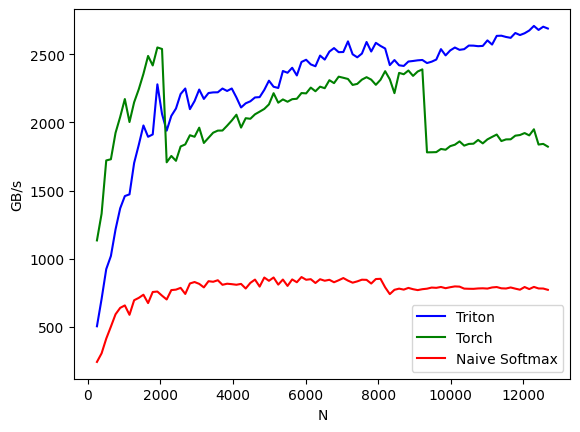

softmax-performance:
          N       Triton        Torch  Naive Softmax
0     256.0   504.621340  1134.313107     243.165210
1     384.0   704.901488  1330.029773     306.093684
2     512.0   923.939827  1720.693882     413.980971
3     640.0  1019.868096  1729.477536     501.822726
4     768.0  1214.975097  1923.143281     592.599483
5     896.0  1369.640315  2040.145237     639.613788
6    1024.0  1459.386270  2171.044686     657.532656
7    1152.0  1472.099308  2002.392485     588.702755
8    1280.0  1702.342671  2147.356065     695.645863
9    1408.0  1835.330327  2243.123006     712.875270
10   1536.0  1977.305777  2355.889285     736.003516
11   1664.0  1894.259989  2487.114519     674.655149
12   1792.0  1911.535097  2417.380353     756.068256
13   1920.0  2278.825776  2549.398204     759.248692
14   2048.0  2061.264982  2538.154929     729.049419
15   2176.0  1939.126600  1707.108642     701.090058
16   2304.0  2047.548025  1753.633920     769.875394
17   2432.0  2101.619211 

In [6]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch', 'naive_softmax'],  # possible values for `line_arg``
        line_names=["Triton", "Torch", "Naive Softmax"],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: softmax(x))
    if provider == 'naive_softmax':
        ms = triton.testing.do_bench(lambda: naive_softmax(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)

In the above plot, we can see that:
 - Triton is 4x faster than the Torch JIT. This confirms our suspicions that the Torch JIT does not do any fusion here.
 - Triton is noticeably faster than :code:`torch.softmax` -- in addition to being **easier to read, understand and maintain**.
   Note however that the PyTorch `softmax` operation is more general and will work on tensors of any shape.

